# A coupled flow-flexure-fracture model for viscoelastic, shallow ice shelves

## Problem description

Consider a 1D floating ice shelf, flowing viscously in accordance with the SSA, with depth-averaged velocity $u$ and net depth-integrated stress of $H\overline{\sigma}$, but with a viscoelastic deflection $\eta$ and bending moment $M$ resulting in a nonzero height above buoyancy, $h_{ab}$. The shelf will melt backward from the front at exactly the flow rate, which will save us having to track the ice front progression. The shelf obeys the three equations below, presented in [Macayeal et al. (2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3):

$$M'' - \rho_wgh_{ab} + H\overline{\sigma}\eta'' = 0$$
$$\frac{12(1 - \mu^2)}{EH^3}M + \eta'' = \Phi$$
$$\dot{\Phi} + u\Phi'= -\frac{3}{\nu H^3}M$$

The first equation is the balance of forces in a flowing, viscoelastically-flexing medium, and the second two incorporate the viscoelastic constitutive relation. $\Phi$ is introduced by MacAyeal et al. as a "variable of convenience," allowing us to write an inherenty fourth-order problem as a system of three coupled second-order problems. As described later, the variables related to flow will be solved independently using icepack [(Shapero et al., 2021)](https://gmd.copernicus.org/articles/14/4593/2021/gmd-14-4593-2021.pdf), and so the above system constitutes a system of three unknowns: the deflection $\eta$, the bending moment $M$, and the variable $\Phi$. 

## Solution strategy

We will first model the system toward steady state geometry and velocity using functionality from icepack, and then solve the above equations iteratively from that steady-state starting point. With superscripts denoting the solution at a given timestep, the $t$th solution will be approximated first by solving the system 

$$\left(M^{(t)}\right)'' - \rho_wg\left(h_{ab}^{(t - 1)} + \eta^{(t)} - \eta^{(t - 1)}\right) + H\overline{\sigma}\left(\eta^{(t)}\right)'' = 0$$
$$\frac{12(1 - \mu^2)}{EH^3}M^{(t)} + \left(\eta^{(t)}\right)'' = \Phi^{(t - 1)}$$

which is a system of two unknowns, $M^{(t)}$ and $\eta^{(t)}$. We will solve this system using Firedrake. The value of $\Phi$ is obtained at each timestep using the third equation, so that 

$$\dot{\Phi}^{(t)} + u\left(\Phi^{(t)}\right)' = -\frac{3}{\nu H^3}M^{(t)},$$

with $M^{(t)}$ having already been computed as above. We will solve this advection equation using the modules [TransportEquation and TransportSolver](https://github.com/chrismiele/weird_flex/blob/main/flow/transport_solver_1D.ipynb), which will soon be incorporated into icepack.

## Variational form

Let $\vartheta$ and $\varphi$ be arbitrary functions in $x$. We must have  

$$\int_x\vartheta\left(M^{(t)}\right)'' - \int_x\vartheta\rho_wg\eta^{(t)} + \int_x \vartheta H\overline{\sigma} \left(\eta^{(t)}\right)'' = \int_x\vartheta\rho_wg\left(h_{ab}^{(t - 1)} - \eta^{(t - 1)}\right)$$
$$\int_x\varphi\frac{12(1 - \mu^2)}{EH^3}M^{(t)} + \int_x\varphi\left(\eta^{(t)}\right)'' = \int_x\varphi\Phi^{(t - 1)}$$

and so, integrating by parts, it follows that 

$$-\int_x\vartheta'\left(M^{(t)}\right)' - \int_x\vartheta\rho_wg\eta^{(t)} - \int_x\left(\vartheta H\overline{\sigma}\right)'\left(\eta^{(t)}\right)' + \left[\vartheta\left(M^{(t)}\right)'\right]_{x_0}^{x_1} + \left[\vartheta H\overline{\sigma}\left(\eta^{(t)}\right)'\right]_{x_0}^{x_1} = 0$$

$$\int_x\varphi\frac{12(1 - \mu^2)}{EH^3}M^{(t)} - \int_x\varphi'\left(\eta^{(t)}\right)' + \left[\varphi\left(\eta^{(t)}\right)'\right]_{x_0}^{x_1} = \int_x\varphi\Phi^{(t - 1)}$$


## Boundary conditions

We consider two setups. 

### 1) Buoyancy moment

First, we may consider the flexure associated with the buoyancy moment of the terminal cliff, as explored by [Reeh (1968)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/on-the-calving-of-ice-from-floating-glaciers-and-ice-shelves/0E16F201FB4FF676826078C7C5F487DE). The boundary conditions for this problem are below:

- At the upstream boundary (to the left, denoted Boundary 1), assume that grounding line acts as a hinge, permitting neither deflection nor bending. Then $\eta_1^{(t)} = M_1^{(t)} = 0$ at every timestep.
- At the downstream boundary (the cliff to the right, denoted Boundary 2), we can impose a no-shear condition, so that $\left(M_2^{(t)}\right)' = 0$ at every timestep. This is enforced by keeping the boundary term

$$\int_\Gamma\varphi\left(M_1^{(t)}\right)' = 0.$$

- On the right boundary, $M_1^{(t)} = -\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)$, where $\varrho$ is the proportion of ice thickness below the waterline [(Lipovsky, 2020)](https://tc.copernicus.org/articles/14/1673/2020/). Note that this proportion is generally not equal to $\frac{\rho_i}{\rho_w}$, but instead will vary with time, as the terminus of the shelf will deflect downward from its equilibrium position. This final boundary condition is enforced by adding the boundary term

$$
\int_\Gamma \vartheta M^{(t)} = -\int_\Gamma\vartheta\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)
$$


### 2) The footloose mechanism

Second, we may consider an upward shear force acting on the terminal cliff, which emerges from a protruding ice foot of length $l$ which spans vertically from the glacier base up to the waterline [(Wagner et al., 2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014GL060832). The boundary conditions for this problem are:

- The upstream boundary still acts as a hinge, with $\eta_1^{(t)} = M_1^{(t)} = 0$.
- The terminus is moment-free, with $M_2^{(t)} = 0$.
- The shear force against the terminus is equal to the difference between gravitational and buoyant forces acting on the proglacial submarine block: $\left(M_1^{(t)}\right)' = (\rho_i - \rho_w)gbl$.

This final constraint is enforced by adding the boundary term

$$\int_\Gamma\varphi\left(M_1^{(t)}\right)' = \int_\Gamma\varphi(\rho_i - \rho_w)gbl$$

## Damage

We'll also include a damage advection law similar in character to that of [Albrecht and Levermann (2012)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/fracture-field-for-largescale-ice-dynamics/ED82A8928F6C65EFA3817CC02745956D), but which uses the elastic curvature, $12\frac{(1 - \mu^2)}{EH^3}M$, as the source of the damage (rather than strain rates due to flow). We introduce damage as $\gamma 12\frac{(1 - \mu^2)}{EH^3}M(1 - D)$ wherever this term is positive, where $D$ is the damage already present in the shelf and $\gamma$ is analogous to the scaling parameter used by Albrecht and Levermann (though the value of $\gamma$ here is completely arbitrary, with our selected values those which happen to provide interesting damage magnitudes). Damage is advecting using TransportEquation.

## Solution and plotting options

We solve the full coupled flow-viscoelastic flexure problem by setting ```flow = true```, or we can solve the relatively simpler scenario of a viscoelastically flexing static shelf (whose geometry, nonetheless, has emerged as a result of modeling flow toward steady state). Eventually, we will have the option of incorporating damage.

In [1]:
flow = True #set to true if solving a coupled flow-flexure problem, false if solving only flexure
footloose = True #otherwise will be buoyancy-driven flexure
damaged = False

gif = True #save multiple images to create a gif, or output a single post-friendly image?

path = '/home/firedrake/H3F/figures/ice_cliff_viscoelastic' #path of preferred destination for saving figures

## Imports

In [2]:
%%capture

from firedrake import *
import icepack
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from operator import itemgetter
import os
import tqdm

!pip install import_ipynb #this block is to allow importing transport_solver, which is not yet a part of icepack
import import_ipynb
os.chdir('/home/firedrake/H3F/notebooks/flow/') #location of the transport solver notebook
from transport_solver_1D import TransportEquation, TransportSolver
os.chdir(path)

## Material parameters

In [3]:
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravitational constant (N/kg)
H_gl = 500 #grounding line thickness in meters
foot_length = 10 #length of the protruding foot, relevant only if footloose == True
year = icepack.constants.year #number of seconds in a year
E_0 = 1e9 #Young's Modulus (Pa)
E = E_0 #define E, but maintain the initial value for later reference
μ = 1/3 #Poisson's Ratio
ν = 1e14/year #flexural viscosity in (Pa yr). We'll use this value only for n = 1
T = Constant(273.15) #temperature in K
glen_exponent = 3 #set to 1 or 3 only. Value of A not explored for other n
u_gl = 100 #grounding line velocity boundary condition in meters per year

A_0 = icepack.rate_factor(T) if glen_exponent == 3 else 1/(ν_0/1e6) #make A consistent with ν for n = 1
A = A_0
γ = 1e7 if footloose else 1e6 #very poorly constrained scaling parameter for damage law
#I've only really looked at this for the exact setup shown on the poster
#Appropriate values for other setups tbd...

## Meshing 

In [4]:
nx = 1000 #number of nodes
Lx = 10000 #length of domain
mesh = IntervalMesh(nx, Lx)

Δt = 1/100 #timestep 
num_years = 10 #choose how many years to model
num_timesteps = int(num_years/Δt) + 1 #number of timesteps

Q1 = FunctionSpace(mesh, 'CG', 3)
Q = Q1*Q1 #mixed function space for (η, M)

η, M = TrialFunctions(Q) #trial functions for the deflection η, moment M_xx, and whatever Φ is
φ, ϑ = TestFunctions(Q) #test functions
q = Function(Q) #q = (η solution, M solution)
η_prev = Function(Q1).project(Constant(0))
damage = Function(Q1).project(Constant(0)) #initial damage profile

u_trial = TrialFunction(Q1) #trial function for the velocity
v = TestFunction(Q1) #test function for velocity
u = Function(Q1) #this variable will store the actual velocity solution

x, = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting longitudinal profiles

## Spin up geometry to steady state

Obtain initial (pre-flexure) steady state by iteratively solving for velocity $u$ and thickness $H$. We can do this using the observation that, in the case of 1D shallow-shelf flow, the general solution for $\overline{\tau}$ is 

$$\overline{\tau} = \frac{1}{4}\rho_igH - \frac{1}{4H}\rho_wg(s - H)^2,$$

and so the velocity field must satisfy 

$$ u' = A\left(\frac{1}{4}\rho_igH - \frac{1}{4H}\rho_wg(s - H)^2\right)^n.$$

We can easily put this into the appropriate variational form for solving with Firedrake, given arbitrary function $v = v(x)$:

$$\int_xvu' = \int_xvA\tau^n.$$


Meanwhile, we will updated the surface and basal elevations each step via icepack's advection solver. Note also that the depth-averaged net stress associated with this solution is 

$$\overline{σ} = -\rho_w g\frac{(s - H)^2}{2H},$$

which will be used in the flexure solver later. 

In [5]:
######################################
######################################
### initialize values to be solved ###
######################################
######################################

H = Function(Q1).project(Constant(H_gl)) #initial thickness
s = Function(Q1).project((1 - ϱ)*H) #initial surface elevation
b = Function(Q1).project(-ϱ*H) #initial basal elevation

##############################
##############################
### initialize the solvers ###
##############################
##############################

conservative_transport_model = TransportEquation(field_name = 'field', conservative = True) #for conservative advection problems
conservative_transport_solver = TransportSolver(conservative_transport_model) #e.g., mass transport

BC_u = DirichletBC(Q1, u_gl, 1) #constrain velocity at the grounding line to be u_gl

###########################
###########################
### attain steady state ###
###########################
###########################

residence_time = int(Lx/u_gl) #estimated number of years for grounding line ice to reach the terminus
dt = 1 #set the timestep to one year

for step in tqdm.trange(residence_time):
    
    τ = Function(Q1).project((1/4*ρ_i*g*H - 1/(4*H)*ρ_w*g*(s - H)**2)/1e6) #analytic, 1D expression for τ
    a = grad(u_trial)[0]*v*dx 
    L = v*A*τ**glen_exponent*dx
    solve(a == L, u, bcs = [BC_u]) #obtain the velocity

    s = conservative_transport_solver.prognostic_solve(dt, field = s, velocity = u, #update the surface
                                            field_accumulation = Constant(0), field_inflow = s)
    
    b = conservative_transport_solver.prognostic_solve(dt, field = b, velocity = u, #update the base
                                            field_accumulation = Constant(0), field_inflow = b)
    H = Function(Q1).project(s - b)

#########################################
#########################################
### calculate the effective viscosity ###
#########################################
#########################################
        
ν = Function(Q1).project(1e6/(A*τ**(glen_exponent - 1))) #if n = 1, this remains ν_0
σ = Function(Q1).project(-b**2/(2*H)*ρ_w*g)

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 36.96it/s]


## Plot the initial steady-state configuration

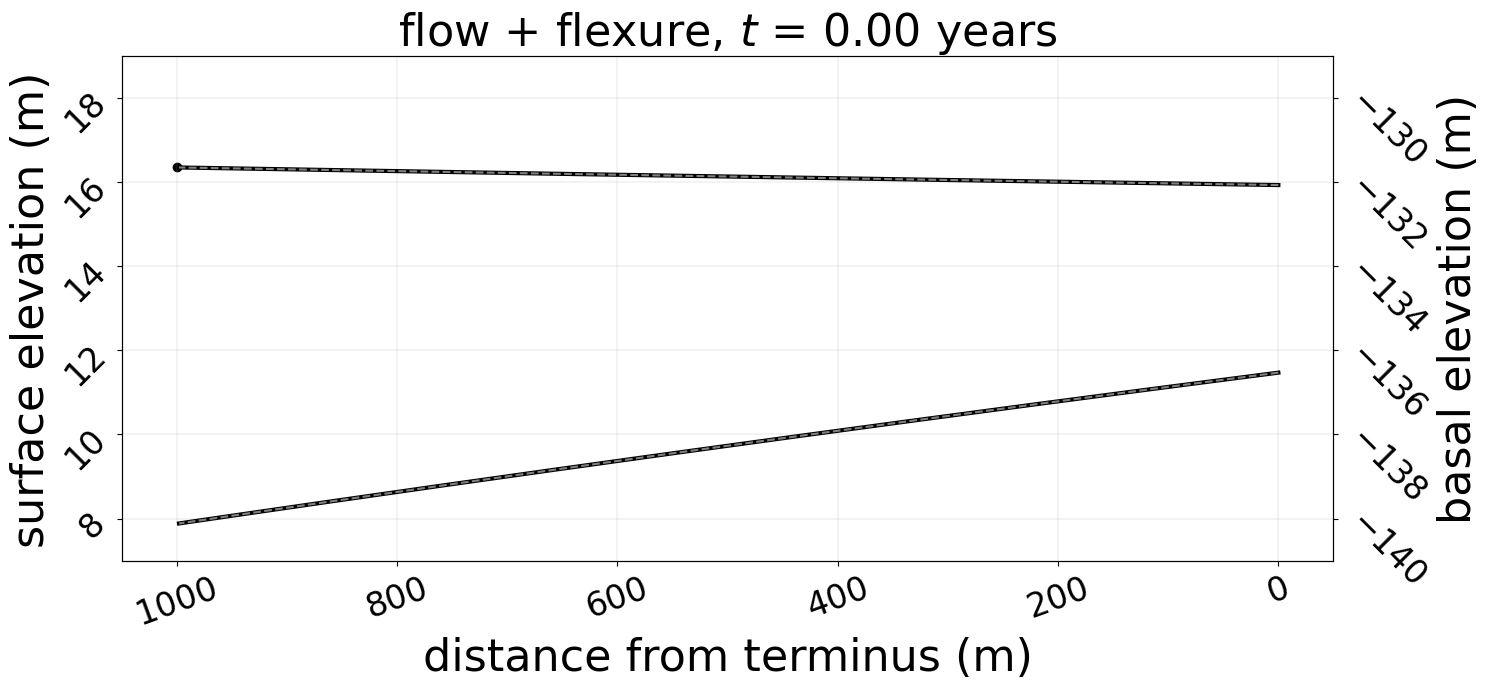

In [6]:
y_min, y_max = 7, 19 #for bounding the plots. if unsure which values are appropriate, comment this line out
title_size = 32
tick_size = 24
label_size = 32
start = -1000 #how close to the terminus should we view?

offset = int(H.at(Lx, tolerance = 1e-10)*0.99) - 2 #for shifting up the base to plot alongside surface elevation
point = Lx + start #we'll plot the progression of a point for sense of motion in the gifs
s1 = s.at(point, tolerance = 1e-10) #surface elevation at our chosen point

s_0_profile = s.at(X, tolerance = 1e-10) #the profiles to plot
b_0_profile = Function(Q1).project(b + offset).at(X, tolerance = 1e-10)

if not flow and not damaged: #find an appropriate title for the plot
    name = 'flexure'
elif not damaged:
    name = 'flow + flexure'
else:
    name = 'flow + flexure + damage'

if gif:

    fig, ax = plt.subplots(figsize = (15, 7))
    plt.title(f'{name}, $t$ = 0.00 years', fontsize = title_size)
    
    plt.plot(s_0_profile[:start:-1], color='k', linewidth = 3)
    plt.plot(b_0_profile[:start:-1], linewidth = 3, color='k')
    plt.plot(s_0_profile[:start:-1], color='grey', linestyle = 'dashed')
    plt.plot(b_0_profile[:start:-1], color = 'grey', linestyle = 'dashed')
    
    if flow:    
        plt.scatter(Lx - point, s1, color = 'k')
    
    plt.xlabel('distance from terminus (m)', fontsize = label_size)
    plt.ylabel('surface elevation (m)', fontsize = label_size)
    plt.yticks(rotation = 45, fontsize = tick_size)  
    plt.xticks(rotation = 20, fontsize = tick_size)
    try:
        plt.ylim(y_min, y_max)
    except:
        pass
    
    plt.gca().invert_xaxis()
    plt.grid(linewidth=0.2)

    try:
        plt.twinx()
        plt.ylim(y_min - offset, y_max - offset)
        plt.ylabel('basal elevation (m)', fontsize = label_size)
        plt.yticks(rotation = -45, fontsize = tick_size)
    except:
        pass

    plt.tight_layout()
    plt.savefig('iteration_0')

else:
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.title('steady state geometry (pre-flexure)', fontsize = title_size)
    plt.plot(s_0_profile[::-1], color = 'k', linewidth = 3)
    plt.plot(b.at(X, tolerance = 1e-10)[::-1], color = 'k', linewidth = 3)
    plt.xlabel('distance from terminus (m)', fontsize = label_size)
    plt.ylabel('surface elevation (m)', fontsize = label_size)
    plt.xticks(fontsize = tick_size, rotation = 20)
    plt.yticks(fontsize = tick_size, rotation = 45)
    plt.gca().invert_xaxis()
    plt.grid(linewidth=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    try:
        corner_x = -start
        corner_y = float(b.at(Lx + start, tolerance = 1e-10) - s.at(0, tolerance = 1e-10) + s.at(Lx + start, tolerance = 1e-10))
        box_length = start
        box_height = s.at(0, tolerance = 1e-10) - corner_y
        box = patches.Rectangle((corner_x, corner_y), box_length, box_height, linewidth = 3, 
                                edgecolor = 'purple', facecolor = 'none', linestyle = 'dashed', label = 'focus area')
        ax.add_patch(box)
    except:
        pass
    plt.legend(loc = 'lower right', fontsize = label_size)
    plt.tight_layout()
    plt.savefig('initial_configuration')

## Choose an initial value for $\Phi$

Before solving the viscoelastic flexure problem, we need to choose what initial value to use for $\Phi^{(0)}$.

We'll find the value which would emerge from a purely-viscous flexure problem. In this case, the initial system of three equations becomes

$$M'' - \rho_wg\eta + H\overline{\sigma}\eta'' = 0$$
$$\dot{\eta}'' + \frac{3}{\nu H^3}M = 0,$$

which we can approximate further by discretizing the time step:

$$M'' - \rho_wg\dot{\eta}\Delta t + H\overline{\sigma}\dot{\eta}''\Delta t = 0$$
$$\dot{\eta}'' + \frac{3}{\nu H^3}M = 0.$$

Once this system has been solved, we will set $\Phi^{(0)} := \eta'' \approx \dot{\eta}''\Delta t = -\frac{3}{\nu H^3}M\Delta t$. 

Using the same function spaces, test functions, and trial functions as defined earlier, the variational form for this simplified problem is 

$$-\int_x\vartheta'M' - \int_x\vartheta\rho_wg\dot{\eta}\Delta t - \int_x\left(\vartheta H\overline{\sigma}\right)'\dot{\eta}'\Delta t + \left[\vartheta M'\right]_{x_0}^{x_1} + \left[\vartheta H\overline{\sigma}\dot{\eta}'\Delta t\right]_{x_0}^{x_1} = 0$$

$$ -\int_x\varphi'\dot{\eta}' + \int_x\varphi\frac{3}{\nu H^3}M + \left[\varphi\dot{\eta}'\right]_{x_0}^{x_1} = 0.$$

We'll use boundary conditions relating to the selected problem (buoyancy moment or footloose). 

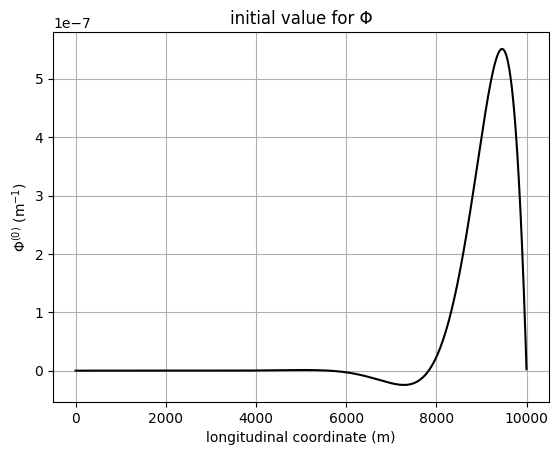

In [7]:
σ = σ if flow else Function(Q1).project(Constant(0)) 
a = -grad(ϑ)[0]*grad(M)[0]*dx - ϑ*ρ_w*g*η*Δt*dx - grad(ϑ*H*σ)[0]*grad(η)[0]*Δt*dx - grad(φ)[0]*grad(η)[0]*dx + φ*3/(ν*H**3)*M*dx
a += φ*grad(M)[0]*ds(2) 
bc_η = DirichletBC(Q.sub(0), 0, 1) #η = 0 on left boundary

if footloose:
    F = Function(Q1).project((ρ_i - ρ_w)*g*b*foot_length)
    L = φ*F*ds(2)
    bc_M = DirichletBC(Q.sub(1), 0, (1, 2)) #M = 0 on both boundaries

else:
    a += ϑ*M*ds
    L = -ϑ*1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1)*ds
    bc_M = DirichletBC(Q.sub(1), 0, 1) #M = 0 on left boundary only

solve(a == L, q, bcs = [bc_M, bc_η])

Φ = Function(Q1).project(-3/(ν*H**3)*q[1]*Δt)

plt.figure()
plt.title('initial value for Φ')
plt.plot(Function(Q1).project(Φ).at(X, tolerance = 1e-10), color = 'k')
plt.ylabel('Φ$^{(0)}$ (m$^{-1}$)')
plt.xlabel('longitudinal coordinate (m)')
plt.grid()

## Solve with firedrake

From the variational form derived above, define 

$$ a := -\int_x\vartheta'\left(M^{(t)}\right)' - \int_x\vartheta\rho_wg\eta^{(t)} - \int_x\left(\vartheta H\overline{\sigma}\right)'\left(\eta^{(t)}\right)' + \int_x\varphi\frac{12(1 - \mu^2)}{EH^3}M^{(t)} - \int_x\varphi'\left(\eta^{(t)}\right)' + \int_\Gamma \vartheta M^{(t)}$$

$$L := \int_x\vartheta\rho_wg\left(h_{ab}^{(t - 1)} - \eta^{(t - 1)}\right) + \int_x\varphi\Phi^{(t - 1)} - \int_\Gamma\vartheta\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)$$

We will solve the problem $a = L$ subject to the boundary conditions discussed earlier.

100%|███████████████████████████████████████| 1001/1001 [09:03<00:00,  1.84it/s]


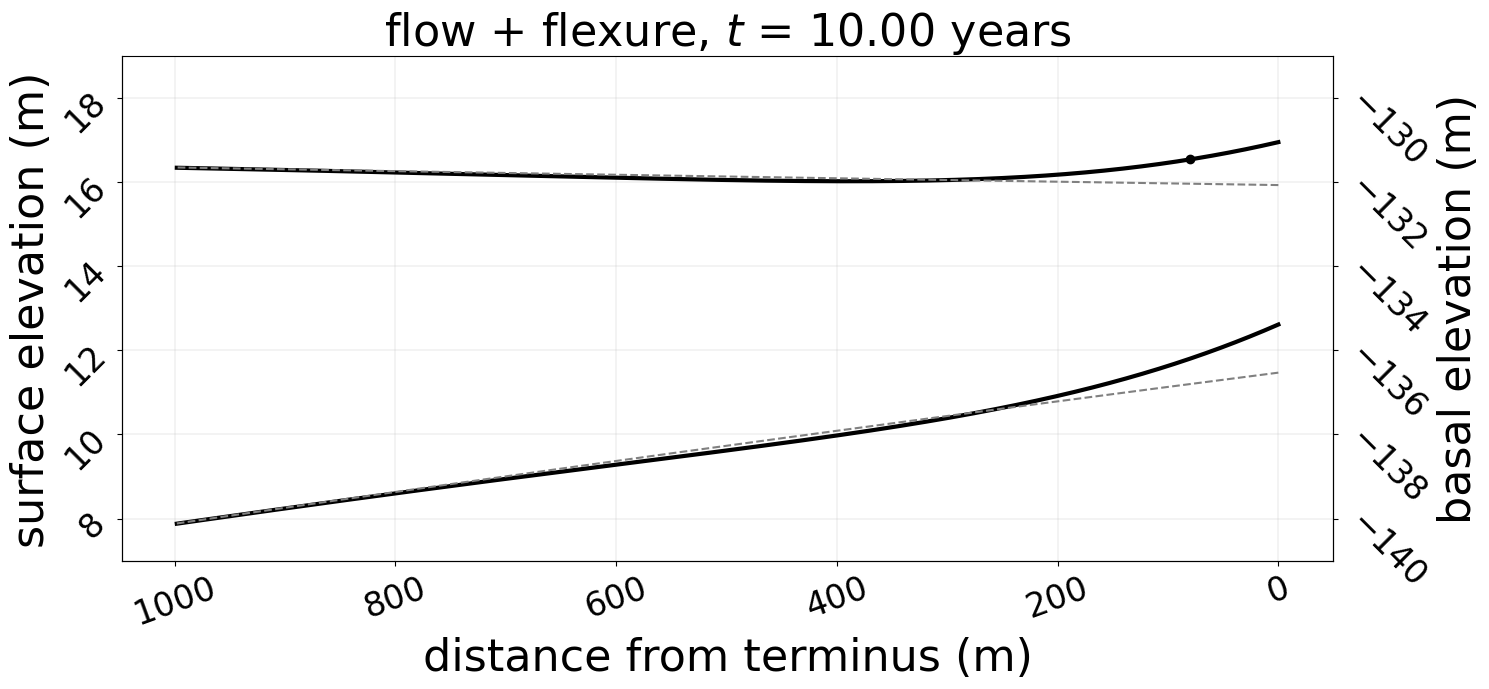

In [8]:
if not gif:
    fig, ax = plt.subplots(figsize = (15, 7))
    plt.plot(s_0_profile[:start:-1], color = 'grey', linestyle = 'dashed', linewidth = 3, label = 't = 0 years')
    plt.plot(b_0_profile[:start:-1], color = 'grey', linestyle = 'dashed', linewidth = 3)

####################################
####################################
### initialize remaining solvers ###
####################################
####################################

nonconservative_transport_model = TransportEquation(field_name = 'field', conservative = False) #for nonconservative advection
nonconservative_transport_solver = TransportSolver(nonconservative_transport_model) #e.g., Φ, eventually damage

u = u if flow else Function(Q1).project(Constant(0)) #set velocity to 0 if flow == False

#########################
#########################
### solve iteratively ###
#########################
#########################

for step in tqdm.trange(num_timesteps):

    #########################
    #########################
    ### obtain flow field ###
    #########################
    #########################
    
    if flow:
        
        τ = Function(Q1).project((1/4*ρ_i*g*H - 1/(4*H)*ρ_w*g*(s - H)**2)/1e6) 
        a = grad(u_trial)[0]*v*dx 
        L = v*A*τ**glen_exponent*dx
        solve(a == L, u, bcs = [BC_u]) #obtain the velocity

        s = conservative_transport_solver.prognostic_solve(Δt, field = s, velocity = u, #update the surface
                                                field_accumulation = Constant(0), field_inflow = s)
        
        b = conservative_transport_solver.prognostic_solve(Δt, field = b, velocity = u, #update the thickness
                                                field_accumulation = Constant(0), field_inflow = b)
        
        H = Function(Q1).project(s - b) #thickness changes only if flow == True
        σ = Function(Q1).project(-b**2/(2*H)*ρ_w*g) #update the flow stress

        ##################################
        ### this part doesn't work yet ###
        ##################################
        
        if damaged: 
            ε = Function(Q1).project(max_value(12*(1 - μ**2)/(E*H**3)*q[1], 0))
            damage_accumulation = Function(Q1).project(γ*ε*(1 - damage)) #taken from DamageTransport's "sources" function
            damage = nonconservative_transport_solver.prognostic_solve(Δt, field = damage, velocity = u, 
                                                                       field_accumulation = damage_accumulation, 
                                                                       field_inflow = damage)
            A = Function(Q1).project(A_0/(1 - damage)**glen_exponent)
            ν = Function(Q1).project(1e6/(A*τ**(glen_exponent - 1)))
            E = Function(Q1).project(E_0*(1 - damage))

        
    ##################################
    ##################################
    ### update buoyancy parameters ###
    ##################################
    ##################################
    
    h_ab = Function(Q1).project(s - (1 - ρ_i/ρ_w)*H)
    ϱ = Function(Q1).project(1 - s/H)
    
    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################
    
    a = -grad(ϑ)[0]*grad(M)[0]*dx - ϑ*ρ_w*g*η*dx + φ*12*(1 - μ**2)/(E*H**3)*M*dx - grad(ϑ*H*σ)[0]*grad(η)[0]*dx
    a += -grad(φ)[0]*grad(η)[0]*dx + φ*grad(M)[0]*ds(2) 
    L = ϑ*ρ_w*g*(h_ab - η_prev)*dx + φ*Φ*dx
                    
    if footloose:
        F = Function(Q1).project((ρ_i - ρ_w)*g*b*foot_length)
        L += φ*F*ds(2)

    else:
        a += ϑ*M*ds
        L += -ϑ*1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1)*ds

    solve(a == L, q, bcs = [bc_M, bc_η])
    
    #######################################
    #######################################
    ### update and advect stored values ###
    #######################################
    #######################################
    
    Δη = Function(Q1).project(q[0] - η_prev)
    η_prev = Function(Q1).project(q[0])
    s = Function(Q1).project(s + Δη)
    b = Function(Q1).project(b + Δη)

    Φ_accumulation = Function(Q1).project(-3/(ν*H**3)*q[1])
    Φ = nonconservative_transport_solver.prognostic_solve(Δt, field = Φ, velocity = u, field_inflow = Φ,
                                                          field_accumulation = Φ_accumulation)
    η_prev = nonconservative_transport_solver.prognostic_solve(Δt, field = η_prev, velocity = u, field_inflow = η_prev,
                                                           field_accumulation = Constant(0))
    


    ####################################################
    ####################################################
    ### plot as multiple images for making a gif... ####
    ####################################################
    ####################################################
    
    if gif:

        try:
            point = float(point + u.at(point)*Δt)
            s1 = s.at(point, tolerance = 1e-10)
        except:
            point = Lx + start
            s1 = s.at(point, tolerance = 1e-10)
        
        if step % 5 == 0:
            
            fig, ax = plt.subplots(figsize = (15, 7))

            try:
                plt.ylim(y_min, y_max)
            except:
                pass
                
            plt.title(f'{name}, $t$ = {step*Δt:.2f} years', fontsize = title_size)
            plt.xlabel('distance from terminus (m)', fontsize = label_size)
            plt.ylabel('surface elevation (m)', fontsize = label_size)
            plt.xticks(fontsize = tick_size, rotation = 20)
            plt.yticks(fontsize = tick_size, rotation = 45)
            plt.plot(s.at(X, tolerance = 1e-10)[:start:-1], color='k', linewidth = 3)
            plt.plot(Function(Q1).project(b + offset).at(X, tolerance = 1e-10)[:start:-1], 
                     linewidth = 3, color='k')
            plt.plot(s_0_profile[:start:-1], color = 'grey', linestyle = 'dashed')
            plt.plot(b_0_profile[:start:-1], color = 'grey', linestyle = 'dashed')

    
            if flow:
                plt.scatter(Lx - point, s1, color = 'k')
            
            plt.gca().invert_xaxis()
            plt.grid(linewidth=0.2)

            try:
                plt.twinx()
                plt.ylim(y_min - offset, y_max - offset)
                plt.ylabel('basal elevation (m)', fontsize = label_size)
                plt.yticks(rotation = -45, fontsize = tick_size)
            except:
                pass
            
            ax.spines['top'].set_visible(False)
            plt.tight_layout()
            plt.savefig(f'iteration_{step + 1}')
        
        if step < num_timesteps - 1:
            plt.close() #save all plots but only show the last iteration

    ###############################
    ###############################
    ### ...or as a single image ###
    ###############################
    ###############################

    else:

        color = 0.8*(1 - step/num_timesteps)
    
        if step in [num_timesteps - 1]:
            plt.plot(s.at(X, tolerance = 1e-10)[:start:-1], color = str(color), linestyle = 'solid',
                     linewidth = 3, label = f't = {num_years} years')
            plt.plot(Function(Q1).project(b + offset).at(X, tolerance = 1e-10)[:start:-1], 
                     linewidth = 3, linestyle = 'solid', color = str(color))
        
        # elif step % 100 == 0:
        #     plt.plot(s.at(X, tolerance = 1e-10)[:start:-1], color = str(color), linewidth = 3)
        #     plt.plot(Function(Q1).project(b + offset).at(X, tolerance = 1e-10)[:start:-1], 
        #              linewidth = 3, color = str(color))

if not gif:
    
    plt.legend(loc = 'center left', fontsize = label_size)
    
    try:
        plt.ylim(y_min, y_max)
    except:
        pass
        
    plt.xlabel('distance from terminus (m)', fontsize = label_size)
    plt.ylabel('surface elevation (m)', fontsize = label_size)
    plt.yticks(fontsize = tick_size, rotation = 45)
    plt.xticks(fontsize = tick_size, rotation = 20)
    plt.gca().invert_xaxis()
    plt.grid(linewidth=0.2)
    
    try:
        plt.twinx()
        plt.ylim(y_min - offset, y_max - offset)
        plt.ylabel('basal elevation (m)', fontsize = label_size)
        plt.yticks(fontsize = tick_size, rotation = -45)
    except:
        pass
    
    plt.tight_layout()
    plt.savefig(f'{name}')
    plt.show()

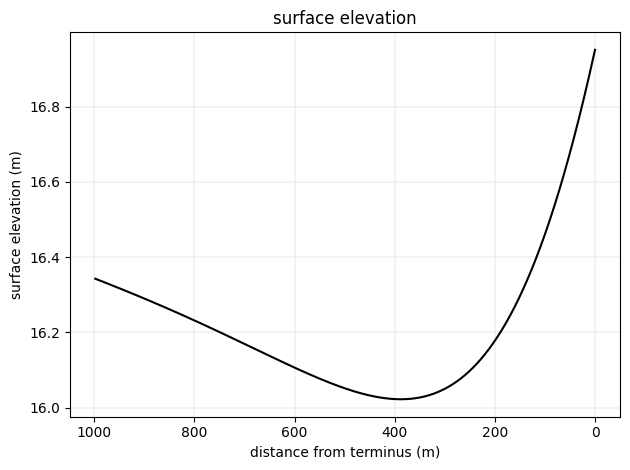

In [9]:
plt.figure()
plt.title('surface elevation')
plt.plot(s.at(X, tolerance = 1e-10)[:start:-1], color = 'k')
plt.xlabel('distance from terminus (m)')
plt.ylabel('surface elevation (m)')
plt.gca().invert_xaxis()
plt.grid(linewidth=0.2)
plt.tight_layout()
# plt.savefig(f'{name}_surface_only')
plt.show()

## Verify that the solution satisfies the initial governing equations

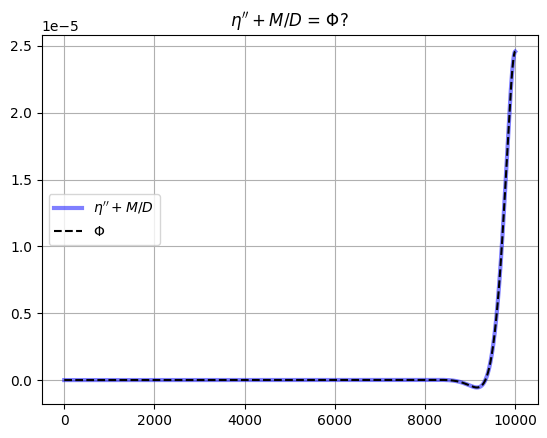

In [10]:
LHS = Function(Q1).project(grad(grad(q[0]))[0, 0] + 12*(1 - μ**2)/(E*H**3)*q[1])
LHS_label = '$η\'\' + M/D$'
RHS_label = '$Φ$'

plt.figure()
plt.title(f'{LHS_label} = {RHS_label}?')
plt.plot(LHS.at(X, tolerance = 1e-10), color = 'blue', linewidth = 3, alpha = 0.5, label = LHS_label)
plt.plot(Φ.at(X, tolerance = 1e-10), color = 'k', linestyle = 'dashed', label = RHS_label)
plt.grid()
plt.legend(loc = 'center left')

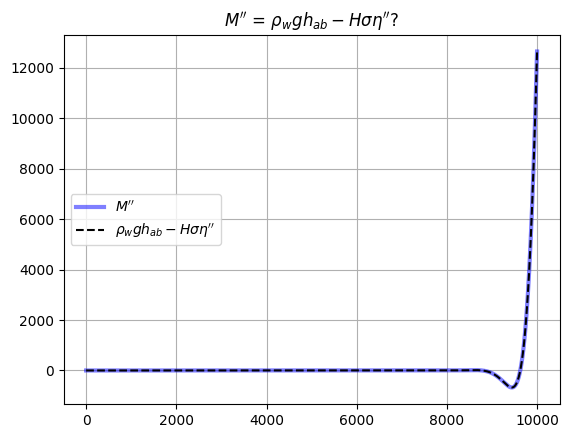

In [11]:
h_ab = Function(Q1).project(s - (1 - ρ_i/ρ_w)*H)
LHS = Function(Q1).project(grad(grad(q[1]))[0, 0])
RHS = Function(Q1).project(ρ_w*g*h_ab - H*σ*grad(grad(q[0]))[0, 0])
LHS_label = '$M\'\'$'
RHS_label = '$ρ_wgh_{ab} - Hση\'\'$'

fig, ax = plt.subplots()
plt.title(f'{LHS_label} = {RHS_label}?')
plt.plot(LHS.at(X, tolerance = 1e-10), color = 'blue', linewidth = 3, alpha = 0.5, label = LHS_label)
plt.plot(RHS.at(X, tolerance = 1e-10), color = 'k', linestyle = 'dashed', label = RHS_label)
plt.grid()
plt.legend(loc = 'center left')